## Running the model

### Postglacial rebound

To run the accompanying `postglacial_rebound.prm` file simulating the post-glacial rebound, described in the [previous notebook](./3_modeling_plate_bending.ipynb), execute the following line with ASPECT:

In [1]:
%%capture
! aspect postglacial_rebound.prm

> In this above cell, it is assumed that the ASPECT directory is installed system-wide or that you are using the HUBzero ASPECT installation. If not, modify the ASPECT executable to the location where it is installed.

In [8]:
# We use the meshio package to visualize the simulation results but since it is not generally installed with python,
# we need to install it separately
! pip install meshio

In [1]:
# Load the relevant libraries

import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.interpolate import griddata
import glob

import sys
from pathlib import Path

# add the utilities file present in the source directory path
# The following path represents the parent directory of all
# gem-notebooks here : https://github.com/geodynamics-hubzero/gem-notebooks/tree/main
source_dir = '../../src/'

# Get absolute path to avoid issues with relative paths
abs_path = str(Path(source_dir).resolve())

if abs_path not in sys.path:
    sys.path.append(abs_path)

import utilities

## Plotting the solution field

### Stress Field
We first look how the modeled normal stresses in the vertical direction evolve over time (animation below). These stresses provide information into the regions of the model that undergo compression (positive) and extension (negative streses) as the applied ice load deforms the elastic lithosphere. 

In [ ]:
def interpolate_solution(f, field):
    
    '''
    Processes a series of VTU solution files in a folder, interpolating stress data onto a uniform grid.
    
    Inputs:
    -----------
    solution_folder : str
        Path to the folder containing solution VTU files (expected in solution/solution-*.vtu)
    field : str
        Name of the field we want to look at in the solution
        
    Returns:
    --------
    numpy.ndarray
        3D array of interpolated solution data with shape:
        [time_steps, x_grid_points, y_grid_points]
    '''
    
    # Set the grid and interpolate solution on it for each time step
    mesh_nodes, sample_data = utilities.read_vtu_file(f)
    points_x = mesh_nodes[:, 0]
    points_y = mesh_nodes[:, 1]

    # Create interpolation grid 
    x_grid = np.linspace(min(points_x), max(points_x), len(points_x))
    y_grid = np.linspace(min(points_y), max(points_y), len(points_y))
    X, Y = np.meshgrid(x_grid, y_grid, indexing='ij')
    
    interp_data = griddata((points_x, points_y), sample_data[field], (X, Y), method='linear')
    
    return (X, Y, interp_data)

In [30]:
plt.ioff()

In [44]:
# Set paths and parameters
output_dir    = './postglacial-rebound/'
field_to_plot = 've_stress_yy'
solution_file_names = sorted(glob.glob(output_dir + 'solution/solution-*.vtu'))

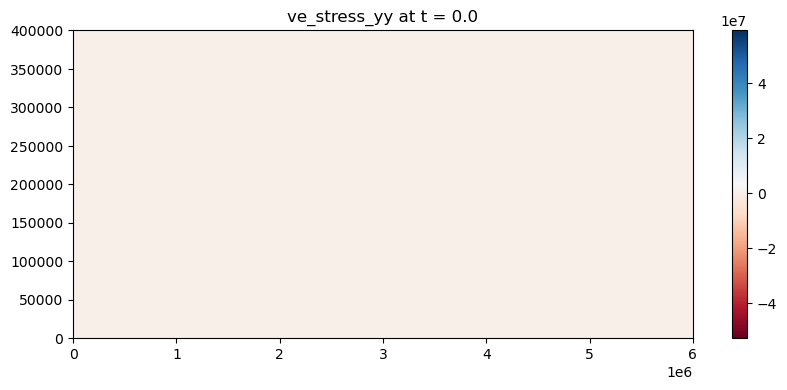

In [38]:
# Create the initial plot
fig, ax1 = plt.subplots(figsize=(10, 4))

all_data = []

# Process each solution file
for i in range(len(solution_file_names)):
    x_mesh, y_mesh, data_per_frame = interpolate_solution(solution_file_names[i], field_to_plot)
    all_data.append(data_per_frame)
    
# Create the pcolormesh plot with first frame
mesh = ax1.pcolormesh(x_mesh, y_mesh, all_data[0], 
                        cmap='RdBu', 
                        shading='auto',
                        vmin=np.min(all_data),
                        vmax=np.max(all_data))

title = ax1.set_title(f"{field_to_plot} at t = 0.0")

cbar = fig.colorbar(mesh, ax=ax1)

In [39]:
def animate(frame):
    
    '''
    Update the solution with time and return the data and the time step
    '''
    
    mesh.set_array(all_data[frame].ravel())    
    title.set_text(f've_stress_yy at frame {frame}')
    
    return [mesh, title]

In [40]:
# Here, we will update the animation on the figure object
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(all_data),
    cache_frame_data=False
)

plt.close(fig)

HTML(ani.to_jshtml())

As the ice load is applied, we note compressive stresses in the center of the model domain (i.e., where the load is applied) and extensional stresses along the sides due to the upward buldge as the lithosphere bends in the center.

### Topography field

In [45]:
def plot_statistics_file (output_dir, field):
    '''
    This function plots the time evolution in the output statistics file created by ASPECT.
    
    Parameters:
    ----------
      output_dir : str
         Directory path where the statistics file is located
      field : str
         Name of the field to plot (e.g., 'RMS Velocity' or 'Max Velocity')
    '''

    statistics = output_dir + "statistics"
    data_stats = utilities.read_statistics(statistics)
    
    # if we want to look at the different columns uncomment the following line
    # data_stats.head()
    
    plt.ion()
    # Since we are interested in the convective vigor, let's plot the
    # RMS velocity and max velocity over time in our model
    fig, ax2 = plt.subplots(figsize=(5, 4))

    ax2.plot(data_stats["Time (years)"], data_stats[field])
    ax2.set_xlabel("Time (years)")
    ax2.set_ylabel(field)

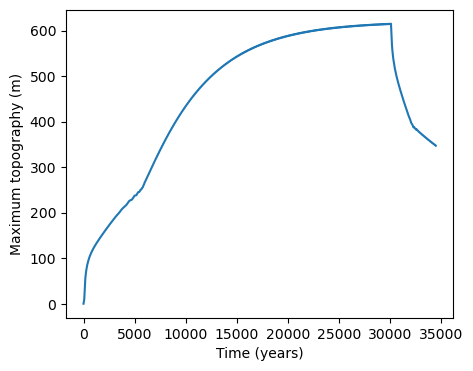

In [46]:
plot_statistics_file(output_dir, 'Maximum topography (m)')

The maximum topography plotted above is the measure of the side buldge formed as the load is applied. As the ice load is applied, the lithospheric buldge increases with time until it achieves a steady height as the underlying mantle flow accommodates the ice load. After the removal of the load (at 30k years), the lithosphere starts to rebound to its original shape and the buldge reduces.

### Ocean Island Loading

To run the accompanying `ocean_island_loading.prm` file simulating the elastic deformation due to the weight of ocean islands, described in the [previous notebook](./3_modeling_plate_bending.ipynb), execute the following line with ASPECT:

In [ ]:
%%capture
! aspect ocean_island_loading.prm

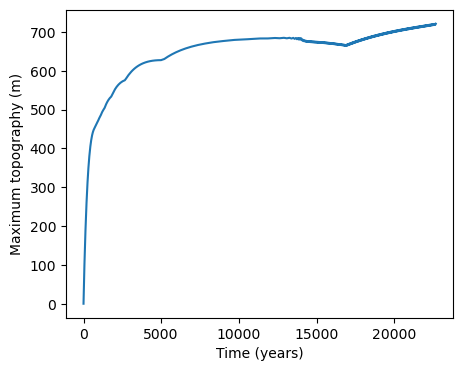

In [47]:
output_dir_1 = './ocean-island-loading/'
plot_statistics_file(output_dir_1, 'Maximum topography (m)')

Similar to the case above, the elastic lithosphere bends under the applied load and develops a side bulge that increases with time until the underlying mantle flow reaches equilibrium, approximately around 5000 years.

### Exercises

You can play with the following `Material Model` parameters to see how the onset of developed topography changes over time :

- Elastic moduli of the lithosphere (last term in `set Elastic shear moduli`) 
- Modify the viscosity of the lithospheric mantle (first term in `set Viscosities`)